In [2]:
import numpy as np
import scipy.linalg
import numpy.linalg as la
import matplotlib.pyplot as plt

In [3]:
def XOR_data(nPoints, fs, k1, k2, sig_dur, a, seed=None):
    if seed is not None:
        np.random.seed(seed)

    N = int(fs * sig_dur)
    noise_amp = np.sqrt(1 - a ** 2)

    #dft matrix
    A = scipy.linalg.dft(N, scale=None)

    # positive examples
    n_pos = int(nPoints/2)
    c = np.zeros((N, n_pos), dtype='complex')
    rand = np.random.normal(loc=0, scale=1, size=(int(n_pos/ 2), 2)).view(np.complex).flatten()
    rand /= np.abs(rand)
    c[k1, :int(n_pos/2)] = rand

    rand = np.random.normal(loc=0, scale=1, size=(int(n_pos/ 2), 2)).view(np.complex).flatten()
    rand /= np.abs(rand)
    c[k2, int(n_pos/2):] = rand
    X_pos = np.sqrt(2) * a * (A @ c).T.real

    # noise for positive egs
    rand = np.random.normal(loc=0, scale=1, size=(N, n_pos, 2)).view(np.complex).squeeze(axis=2)
    rand /= np.abs(rand)
    noise = np.sqrt(2) * noise_amp / np.sqrt(N - 1) * (rand.T @ A).real
    X_pos += noise

    # negative egs
    n_neg = int(nPoints/2)

    # mixed egs
    c = np.zeros((N, int(n_neg/2)), dtype='complex')
    rand = np.random.normal(loc=0, scale=1, size=(1, int(n_neg/2), 2)).view(np.complex).squeeze(axis=2)
    rand /= np.abs(rand)
    c[[k1, k2]] = rand
    X_mixed = a * (A @ c).T.real

    # noise for mixed egs
    rand = np.random.normal(loc=0, scale=1, size=(N, int(n_neg/2), 2)).view(np.complex).squeeze(axis=2)
    rand /= np.abs(rand)
    noise = np.sqrt(2) * noise_amp / np.sqrt(N - 2) * (rand.T @ A).real
    X_mixed += noise

    # noise as negative egs
    c = np.random.normal(loc=0, scale=1, size=(N, int(n_neg/2), 2)).view(np.complex).squeeze(axis=2)
    c /= np.abs(c)
    X_noise = np.sqrt(2) * (A @ c).T.real / np.sqrt(N)
    
    X_neg = np.row_stack((X_mixed, X_noise))
        
    X = np.vstack((X_pos, X_neg))
    y = np.hstack((np.ones(n_pos), np.ones(n_neg) * -1))
    
    return X, y

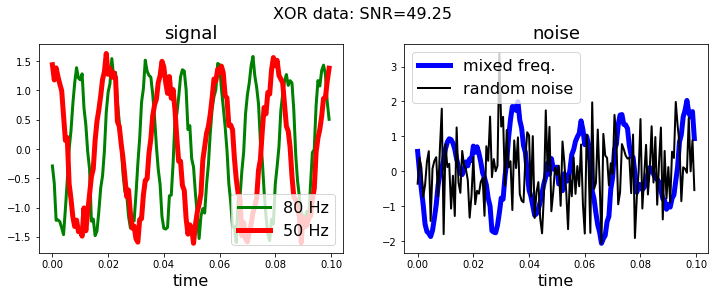

In [4]:
nPoints, fs, sig_dur = 5000, 1000, 0.1
k1, k2 = 5, 8
a = 0.2
freq = [int(k1/ sig_dur), int(k2  / sig_dur)]
X, y = XOR_data(nPoints, fs, k1, k2, sig_dur, a, seed=None)

# plot
snr = a ** 2 / (1 - a ** 2)
N = int(fs * sig_dur)
t = np.arange(N) / fs
nPoints_quarter = int(nPoints / 4)
fig = plt.figure(figsize=(12, 4))
plt.suptitle('XOR data: SNR=%0.2f' % snr, fontsize=16)
ax = fig.add_subplot(121)
plt.title('signal', fontsize=18)
plt.plot(t, X[1250], 'g', lw=3, label='%d Hz' % freq[1])
plt.plot(t, X[0], 'r', lw=5, label='%d Hz' % freq[0])
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('time', fontsize=16)


ax = fig.add_subplot(122)
plt.title('noise', fontsize=18)
plt.plot(t, X[2501], 'b', lw=5, label='mixed freq.')
plt.plot(t, X[-1], 'k', lw=2, label='random noise')
plt.legend(fontsize=16)
plt.xlabel('time', fontsize=16)
plt.subplots_adjust(top=0.85)

plt.savefig('figures/XOR/data_a=%0.2f.png' % a)

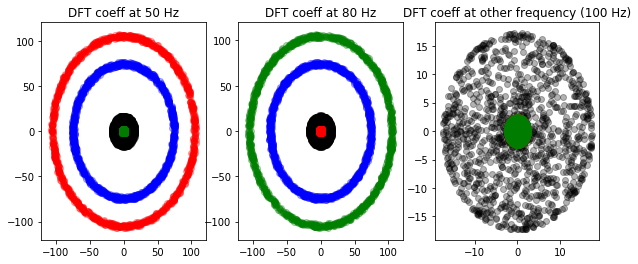

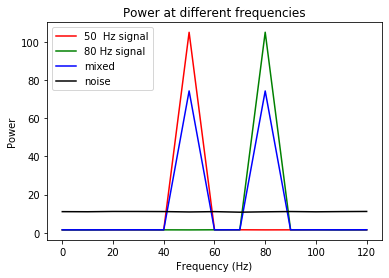

In [7]:
X_pos = X[y == 1]
X_neg = X[y == -1]

N = int(fs * sig_dur)
A = scipy.linalg.dft(N)

dft_pos = X_pos @ A
dft_neg = X_neg @ A

# plot dft coeffs.
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(131)
plt.title('DFT coeff at %d Hz' % freq[0])
plt.scatter(dft_neg[:nPoints_quarter, k1].real, dft_neg[:nPoints_quarter, k1].imag, c='b', alpha=0.3)
plt.scatter(dft_neg[nPoints_quarter:, k1].real, dft_neg[nPoints_quarter:, k1].imag, c='k', alpha=0.3)
plt.scatter(dft_pos[:nPoints_quarter, k1].real, dft_pos[:nPoints_quarter, k1].imag, c='r', alpha=0.3)
plt.scatter(dft_pos[nPoints_quarter:, k1].real, dft_pos[nPoints_quarter:, k1].imag, c='g', alpha=0.3)
# plt.scatter(dft_neg[:, k1].real, dft_neg[:, k1].imag, c='k', alpha=0.3)
# plt.scatter(dft_pos[:, k1].real, dft_pos[:, k1].imag, c='r')

ax = fig.add_subplot(132)
plt.title('DFT coeff at %d Hz' % freq[1])
plt.scatter(dft_neg[:nPoints_quarter, k2].real, dft_neg[:nPoints_quarter, k2].imag, c='b', alpha=0.3)
plt.scatter(dft_neg[nPoints_quarter:, k2].real, dft_neg[nPoints_quarter:, k2].imag, c='k', alpha=0.3)
plt.scatter(dft_pos[:nPoints_quarter, k2].real, dft_pos[:nPoints_quarter, k2].imag, c='r', alpha=0.3)
plt.scatter(dft_pos[nPoints_quarter:, k2].real, dft_pos[nPoints_quarter:, k2].imag, c='g', alpha=0.3)
# plt.scatter(dft_neg[:, k2].real, dft_neg[:, k2].imag, c='k', alpha=0.3)
# plt.scatter(dft_pos[:, k2].real, dft_pos[:, k2].imag, c='r')

k = 10
ax = fig.add_subplot(133)
plt.scatter(dft_neg[:nPoints_quarter, k].real, dft_neg[:nPoints_quarter, k].imag, c='b', alpha=0.3)
plt.scatter(dft_neg[nPoints_quarter:, k].real, dft_neg[nPoints_quarter:, k].imag, c='k', alpha=0.3)
plt.scatter(dft_pos[:nPoints_quarter, k].real, dft_pos[:nPoints_quarter, k].imag, c='r', alpha=0.3)
plt.scatter(dft_pos[nPoints_quarter:, k].real, dft_pos[nPoints_quarter:, k].imag, c='g', alpha=0.3)
plt.title('DFT coeff at other frequency (%d Hz)' % int(k / sig_dur))
# plt.scatter(dft_neg[:, k].real, dft_neg[:, 14].imag, c='k', alpha=0.3)
# plt.scatter(dft_pos[:, k].real, dft_pos[:, 14].imag, c='r')

# # power at different frequencies
power_f1 = np.mean(np.abs(dft_pos[:nPoints_quarter]), axis=0)
power_f2 = np.mean(np.abs(dft_pos[nPoints_quarter:]), axis=0)
power_mixed = np.mean(np.abs(dft_neg[:nPoints_quarter]), axis=0)
power_noise = np.mean(np.abs(dft_neg[nPoints_quarter:]), axis=0)
# power_pos = np.mean(np.abs(dft_pos), axis=0)
# power_neg = np.mean(np.abs(dft_neg), axis=0)

# plt.savefig('figures/XOR/dft_analysis_coefficients_a=%0.2f.png' % a)

n = 13
fig = plt.figure()
plt.title('Power at different frequencies')
plt.plot(np.arange(n) / sig_dur, power_f1[:n], 'r', label='%d  Hz signal' % freq[0] )
plt.plot(np.arange(n) / sig_dur, power_f2[:n], 'g', label='%d Hz signal' % freq[1])
plt.plot(np.arange(n) / sig_dur, power_mixed[:n], 'b', label='mixed')
plt.plot(np.arange(n) / sig_dur, power_noise[:n], 'k', label='noise')

# plt.plot(np.arange(n) / sig_dur, power_pos[:n], 'r', label='signal')
# plt.plot(np.arange(n) / sig_dur, power_neg[:n], 'k', label='noise')
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.legend(loc='upper left', fontsize=10)

# plt.savefig('figures/XOR/dft_analysis_power_a=%0.2f.png' % a)

For discretely sampled signal, 
$X_{RMS} = \sqrt{\dfrac{\sum_{i=1}^n X_i^2}{N}}$

In [8]:
# check input statistics
X_f1, X_f2 = X_pos[:nPoints_quarter], X_pos[nPoints_quarter:]
X_mixed, X_noise = X_neg[:nPoints_quarter], X_neg[nPoints_quarter:]

# RMSE 
print(np.mean(np.sum(X_f1 ** 2, axis=1)) / N, np.mean(np.sum(X_f2 ** 2, axis=1)) / N)
print(np.mean(np.sum(X_mixed ** 2, axis=1))/ N, np.mean(np.sum(X_noise ** 2, axis=1))/ N)

# mean
print(np.mean(X_f1), np.mean(X_f2))
print(np.mean(X_mixed), np.mean(X_noise))

# std
print(np.mean(np.std(X_f1, axis=1)), np.mean(np.std(X_f2, axis=1)))
print(np.mean(np.std(X_mixed, axis=1)), np.mean(np.std(X_noise,axis=1)))

0.9992724150026885 0.9997663517075728
1.0003381948403265 0.9968088284660339
-0.00014898298955106284 -4.1679080037215217e-05
-0.00018537234348737578 0.0037076940713619442
0.9995115504603996 0.9997520012270037
1.000036050050964 0.9942249794559047


In [39]:
# classify the XOR dataset
from sklearn.model_selection import train_test_split
from estimator import RFClassifier, relu, bp_weights_dft
from sklearn.utils import shuffle
import dask

In [40]:
# from dask.distributed import Client
# client = Client(threads_per_worker=7, n_workers=10)
# client

In [41]:
def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return 1 - clf.score(X_test, y_test)

In [42]:
X_perm, y_perm = shuffle(X, y, random_state=0)
# split into test/train
X_train, X_test, y_train, y_test = train_test_split(X_perm, y_perm, test_size=0.3, random_state=42)

In [43]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

# classification
f_gaus = lambda M, N: bp_weights_dft(M, N, lowcut=k1-2, highcut=k2 + 5)
weights = [('bandpass_dft', f_gaus), ('white noise', None)]

# non-linearities
h = {'relu': relu, 'x^2': lambda x: x **2, 'x^3': lambda x: x ** 3}

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

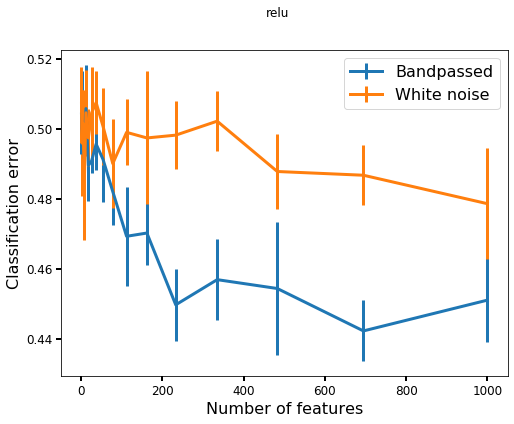

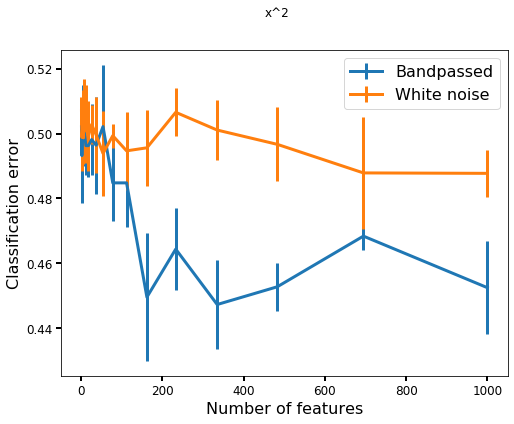

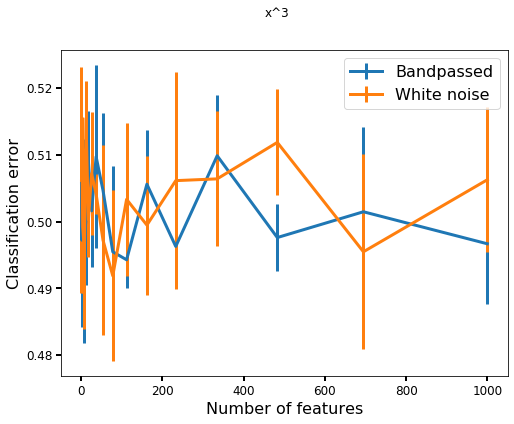

In [45]:
for non_lin in ['relu', 'x^2', 'x^3']:
    results = {wt:[] for (wt, func) in weights}
    for n in n_features:
        for (wt, func) in weights:
            params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h[non_lin]}
            lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                                y_test) for _ in range(5)]
            results[wt].append(np.real(dask.compute(*lazy_results)))

    # compute mean
    mean_err_bp, std_err_bp = np.mean(results['bandpass_dft'], axis=1), np.std(results['bandpass_dft'], axis=1)
    mean_err_wn, std_err_wn = np.mean(results['white noise'], axis=1), np.std(results['white noise'], axis=1)

    # plot
    fig = plt.figure(figsize=(8, 6))
    plt.suptitle('%s' % non_lin)
    ax = fig.add_subplot(111)
    ax.errorbar(n_features, mean_err_bp, yerr=std_err_bp, fmt='-', label='Bandpassed',  markersize=4, lw=3)
    ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='White noise',  
                markersize=4, lw=3)
#     ax.set_yscale('log')
    # plt.xlim([0, 200])
    plt.xlabel('Number of features', fontsize=16)
    plt.ylabel('Classification error', fontsize=16)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
    plt.legend(loc = 'upper right', fontsize=16)

    plt.savefig('figures/XOR/%s_clf_a=%0.2f.png' % (non_lin, a))